In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
# import tensorflow

from keras.layers import (Dropout, Input, Dense, Conv2D, 
                          MaxPooling2D, GlobalAveragePooling2D, 
                          UpSampling2D, Conv2DTranspose, 
                          Reshape, Flatten, Activation, 
                          BatchNormalization)
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.layers import LeakyReLU
from keras.initializers import RandomNormal
from keras.optimizers import Adam

In [2]:
path_to_csv = './Bengali_Handwritten.csv'
data = pd.read_csv(path_to_csv).astype('float32')
data.head()

,1,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.553,0.554,0.555,0.556,0.557,0.558,0.559,0.560,0.561,0.562
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
width, height, channel = 28, 28, 1

In [4]:
shapelen = 98949  # bengval

X = data.iloc[:,1:].values
X = X.reshape((shapelen, width, height))
np.random.shuffle(X)
X.shape

(98949, 28, 28)

In [5]:
X = (X - 127.5) / 127.5

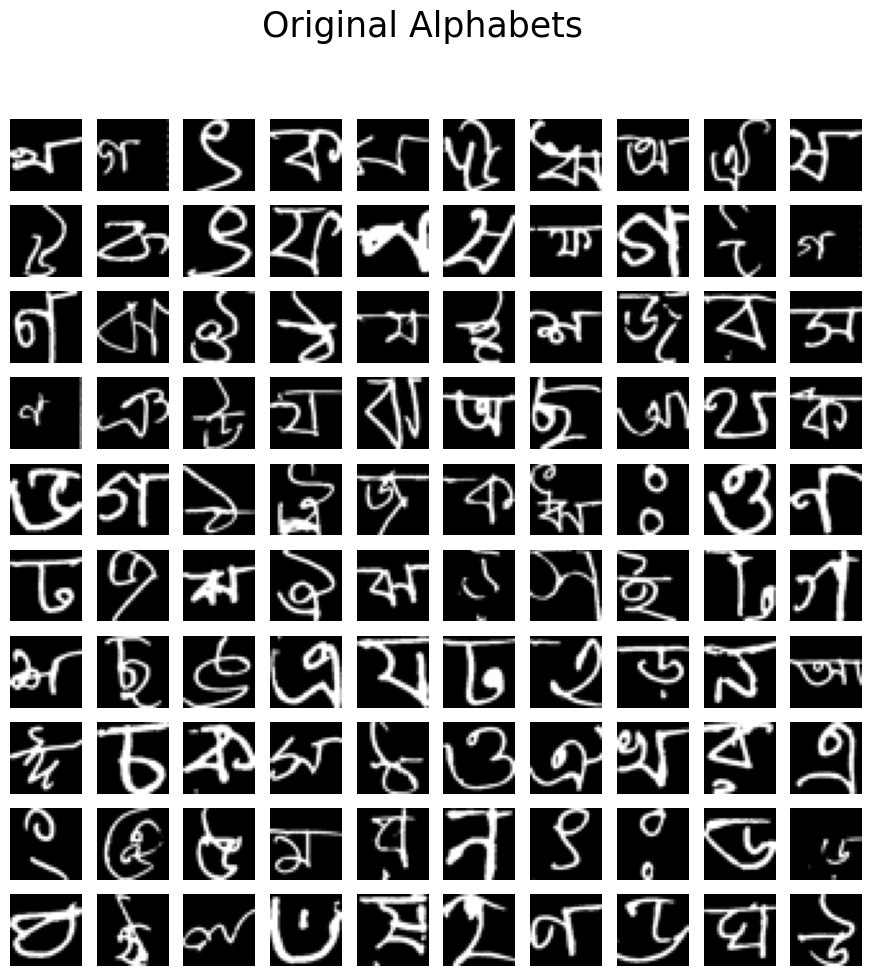

<Figure size 640x480 with 0 Axes>

In [6]:
def show_data(X, title=""):
    plt.figure(figsize=(11,11))
    
    i = 1
    for img in X:
        plt.subplot(10, 10, i)
        plt.imshow(img.reshape((height, width)), cmap='gray')
        plt.axis('off')
        i+=1
        if i>100: break

    plt.suptitle(title, fontsize = 25)
    plt.show()
    plt.savefig('Original_Alphabets.png')
    
show_data(X, title="Original Alphabets")

In [7]:
gen_optimizer = Adam(0.0001, 0.5)
disc_optimizer = Adam(0.0002, 0.5)
noise_dim = 100

In [8]:
def buildGenerator():
    model = Sequential()

    model.add(Dense(1024, input_dim=noise_dim))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    
    model.add(Dense(6272, input_dim=noise_dim))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    
    model.add(Reshape((7, 7, 128)))
    
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (2, 2), padding='same', 
                     kernel_initializer=RandomNormal(0, 0.02)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), padding='same', 
                     kernel_initializer=RandomNormal(0, 0.02)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(channel, (3, 3), padding='same', activation = "tanh", 
                     kernel_initializer=RandomNormal(0, 0.02)))
    
    return model

In [9]:
generator = buildGenerator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              103424    
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 6272)              6428800   
                                                                 
 batch_normalization_1 (Batc  (None, 6272)             25088     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 6272)              0

In [10]:
def buildDiscriminator():
    model = Sequential()
    
    model.add(Conv2D(64, (5, 5), strides=2, padding='same', 
                     kernel_initializer=RandomNormal(0, 0.02), 
                     input_shape=(width, height, channel)))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(128, (5, 5), strides=2, 
                     kernel_initializer=RandomNormal(0, 0.02)))
    model.add(LeakyReLU(0.2))
    
    model.add(Flatten())
    
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=disc_optimizer)
    return model

In [11]:
discriminator = buildDiscriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 5, 5, 128)         204928    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 5, 5, 128)         0         
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               819456    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 256)              

In [12]:
noise = Input(shape=(noise_dim,))
fake_data = generator(noise)
discriminator.trainable = False
output = discriminator(fake_data)
gan = Model(noise, output)
gan.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

In [13]:
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         6632257   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1026305   
                                                                 
Total params: 7,658,562
Trainable params: 6,617,409
Non-trainable params: 1,041,153
_________________________________________________________________


In [14]:
fixed_noise = np.random.normal(0, 1, size=(100, noise_dim))

In [15]:
def show_generated_alphabets(title, epoch):
    imgs = generator.predict(fixed_noise)
    imgs = 0.5 * imgs + 0.5
    plt.figure(figsize=(11,11))
    
    i = 1
    for img in imgs:
        plt.subplot(10, 10, i)
        plt.imshow(img.reshape((height,width)), cmap='gray')
        plt.axis('off')
        i+=1
    plt.suptitle(title, fontsize = 25)
    plt.savefig("./outputs/" + str(epoch)+".png")
    plt.show()

In [16]:
epochs = 81
batch_size = 128
steps_per_epoch = len(X)//batch_size
steps_per_epoch

773

4/4 [==============================] - 4s 48ms/step
0
4/4 [==============================] - 0s 44ms/step
1
4/4 [==============================] - 0s 39ms/step
2
4/4 [==============================] - 0s 45ms/step
3
4/4 [==============================] - 0s 58ms/step
4
4/4 [==============================] - 0s 61ms/step
5
4/4 [==============================] - 0s 46ms/step
6
4/4 [==============================] - 0s 39ms/step
7
4/4 [==============================] - 0s 36ms/step
8
4/4 [==============================] - 0s 41ms/step
9
4/4 [==============================] - 0s 61ms/step
10
4/4 [==============================] - 0s 47ms/step
11
4/4 [==============================] - 0s 39ms/step
12
4/4 [==============================] - 0s 47ms/step
13
4/4 [==============================] - 0s 36ms/step
14
4/4 [==============================] - 0s 40ms/step
15
4/4 [==============================] - 0s 45ms/step
16
4/4 [==============================] - 0s 33ms/step
17
4/4 [===============

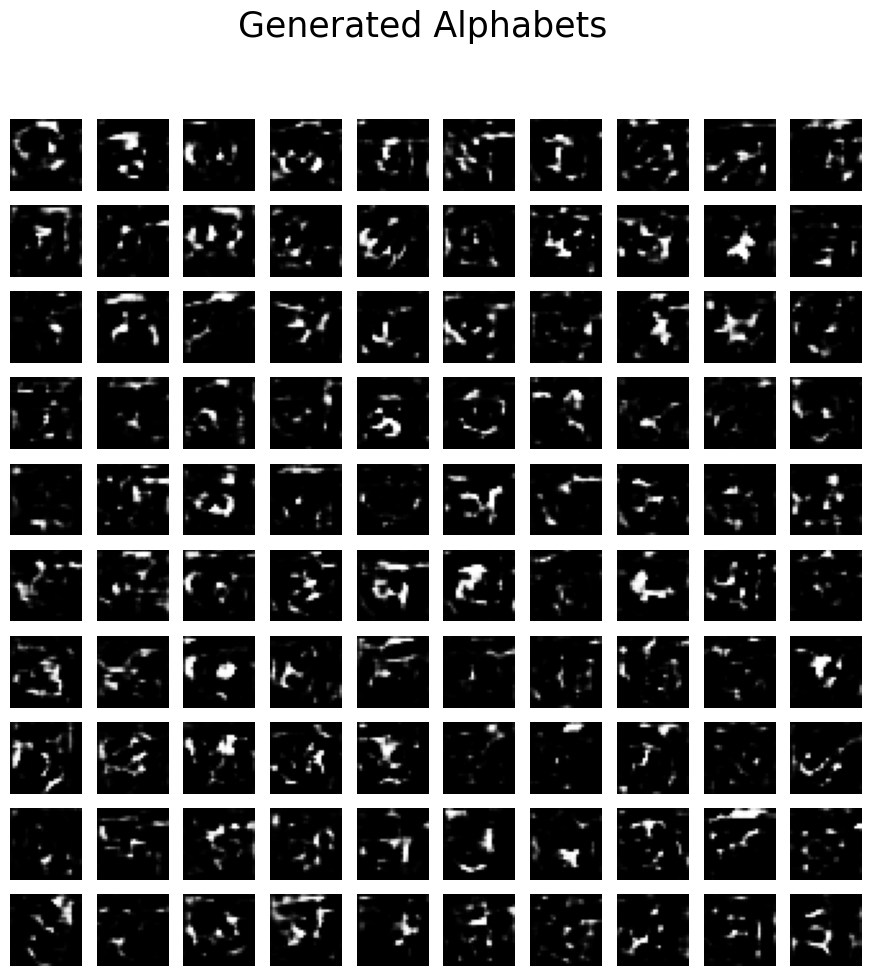

4/4 [==============================] - 0s 67ms/step
0
4/4 [==============================] - 0s 73ms/step
1
4/4 [==============================] - 0s 52ms/step
2
4/4 [==============================] - 0s 77ms/step
3
4/4 [==============================] - 0s 93ms/step
4
4/4 [==============================] - 0s 103ms/step
5
4/4 [==============================] - 0s 83ms/step
6
4/4 [==============================] - 0s 81ms/step
7
4/4 [==============================] - 0s 89ms/step
8
4/4 [==============================] - 0s 76ms/step
9
4/4 [==============================] - 0s 108ms/step
10
4/4 [==============================] - 0s 113ms/step
11
4/4 [==============================] - 1s 89ms/step
12
4/4 [==============================] - 0s 73ms/step
13
4/4 [==============================] - 0s 85ms/step
14
4/4 [==============================] - 0s 61ms/step
15
4/4 [==============================] - 0s 49ms/step
16
4/4 [==============================] - 0s 80ms/step
17
4/4 [============

KeyboardInterrupt: 

: 

In [17]:
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        input_gen = np.random.normal(0, 1, size=(batch_size, noise_dim))
        fake_data = generator.predict(input_gen)
        
        real_data = X[np.random.randint(0, X.shape[0], size=batch_size)]
        real_data = real_data.reshape((batch_size, width, height, channel))
        
        input_disc = np.concatenate((real_data, fake_data))

        label_disc = np.zeros(2*batch_size)
        label_disc[:batch_size] = 0.9
        label_disc[batch_size:] = 0.1
        loss_disc = discriminator.train_on_batch(input_disc, label_disc)

        label_gen = np.ones(batch_size)
        loss_gen = gan.train_on_batch(input_gen, label_gen)
        print(batch)

    print("="*80)
    print("epoch: ", epoch)
    print("discriminator loss: ", loss_disc)
    print("generator loss: ", loss_gen)
    print("="*80)
    
    if epoch % 5 == 0:
        show_generated_alphabets("Generated Alphabets", epoch)